# Exploring the Jaynes-Cummings Hamiltonian with Qiskit Pulse

### Warning
This experiment is not available in the current `ibmq_armonk` device owing to the measurement apparatus configuration. You cannot find cavity resonance within the reasonable scanning range. Try with other devices if you have access to.

### Physics Background

The Jaynes-Cummings model describes a two-level system (qubit) interacting with a single-mode of an electromagnetic cavity (resonator). When a two-level system is placed in a cavity, it couples to the cavity with strength $g$, spontaneously emits its excitation with rate $\gamma$, while the cavity decays with rate $\kappa$. In this tutorial we measure the parameters of a system consisting of a superconducting qubit coupled to a superconducting resonator using Qiskit Pulse.

<img src="images/CQED.png" width="250"/>

This qubit-cavity interaction can be described using the Jaynes-Cummings (JC) Hamiltonian: 

$H_{JC}/\hbar=\omega_r(a^\dagger a) - \frac{1}{2} \omega_q \sigma_z + g (\sigma_+ a + \sigma_- a^\dagger)$

Let's break down this Hamiltonian in different parts: The first part of the Hamiltonian $H_r/\hbar=\omega_r(a^\dagger a)$ describes the resonator. The resonator can be treated as a quantum harmonic oscillator, where $\omega_r$ is the resonator frequency, and $a$ and $a^\dagger$ are the raising a lowering operators of the resonator photons. Note that for simplicity we have omitted the zero point energy of the harmonic oscillator. The next term in the JC Hamiltonian $H_q/\hbar=-\frac{1}{2} \omega_q \sigma_z$ describes the qubit. Here, $\omega_q$ is the qubit frequency, and $\sigma_z$ is the Pauli-Z operator. The final term of the Hamiltonian $H_{rq}/\hbar=g (\sigma_+ a + \sigma_- a^\dagger)$ describes the interaction between the resonator and the qubit: $g$ is the coupling strength between the qubit and the resonator, and the operators $\sigma_+$ and $\sigma_-$ represent exciting and de-exciting the qubit. Based on this interaction term we can see that the process of exciting a qubit leads to a photon loss in the resonator and vice-versa. 

In the limit that detuning between the qubit and the resonator $\Delta=\omega_q-\omega_r$ is less than the coupling strength between the two, $|\Delta|\ll g$, the resonator-qubit system becomes hybridized, leading to coherent excitation swaps which can be useful for certain two-qubit operations. However, for optimal readout, we want to operate the system in the dispersive limit, where the qubit-resonator detuning is much larger than the coupling rate and the resonator decay rate: $|\Delta| \gg g,\kappa$. In this limit the interaction between the qubit and resonator influences each of their frequencies, a feature that can be used for measuring the state of the qubit. We can apply the dispersive approximation in the limit of few photons in the resonator, and approximate the JC Hamiltonian using second-order perturbation theory as: 

$H_{JC(disp)}/\hbar=(\omega_r+ \chi \sigma_z) a^\dagger a + \frac{1}{2} \tilde{\omega}_q \sigma_z$

where $\chi=-g^2/\Delta$ is the dispersive shift (the negative sign is due to the fact that the transmon has a negative anharmonicity), and $\tilde{\omega}_q= \omega_q+g^2/\Delta$ is the modified qubit frequency, experiencing a Lamb shift.

The circuit quantum electrodynamics derivations are discussed in another <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a>. 

### 0. Getting started

We'll first get our basic dependencies and helper functions set up and ready to go.

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

We then extract the default backend configuration and settings for the selected chip.

In [2]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []  # Will allow us to send a larger waveform for our experiments

Next we define some helper functions that we will use for fitting and interpreting our data.

In [3]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),3,2),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# exponential function
def exponential(t,tau,a,offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts,values):
    p0=[np.average(ts),1,0]
    return curve_fit(exponential, ts, values,p0=p0)

### 1. Measuring $\kappa$

Photons decay out of imperfect electromagnetic cavities. The decay rate $\kappa$ for the resonator cavity can be measured by calculating the linewidth of the resonance peak in a resonator spectroscopy scan. Larger values of $\kappa$ imply that the resonator cavity is more lossy. The resonator loss can be quantified using the quality factor $Q=\omega_r/\kappa$; higher $Q$ indicates a lower rate of energy loss from the cavity.

In [4]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
import numpy as np

qubit=0   # qubit used in our experiment

# We will define memory slot channel 0.
mem_slot = 0

readout_time = 4e-6
readout_sigma = 10e-9 

# readout output signal acquisition setup
acquisition_time = readout_time   # We want to acquire the readout signal for the full duration of the readout

In [5]:
# low power drive for the resonator for dispersive readout
# We use a square pulse with a Guassian rise and fall time
#with pulse.build(backend) as readout_drive_low_power:
#    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
#    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
#    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
#    meas_chan = pulse.measure_channel(mem_slot)
#    pulse.play(pulse.GaussianSquare(duration = duration,
#                                    amp = .3,
#                                    sigma = sigma,
#                                    width = width,
#                                    name = 'low power readout tone'), meas_chan)

In [6]:
center_freq = backend_defaults.meas_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 0.3e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2, center_freq+freq_span/2, 41)

In [7]:
# build the pulse sequence for low power resonator spectroscopy
freq = Parameter('freq')
with pulse.build(backend=backend, name='low_power_resonator_sweep') as pulse_low_power:
    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
    acq_chan = pulse.acquire_channel(mem_slot)
    meas_chan = pulse.measure_channel(mem_slot)
    pulse.set_frequency(freq, meas_chan)
    #drive the resonator with low power
    # low power drive for the resonator for dispersive readout
    # We use a square pulse with a Guassian rise and fall time
    pulse.play(pulse.GaussianSquare(duration = duration,
                                    amp = .3,
                                    sigma = sigma,
                                    width = width,
                                    name = 'low power readout tone'), meas_chan)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
                  qubit_or_channel = acq_chan,
                  register = pulse.MemorySlot(mem_slot))

In [8]:
low_power_schedules = [pulse_low_power.assign_parameters({freq: f}, inplace=False) for f in frequencies_range]

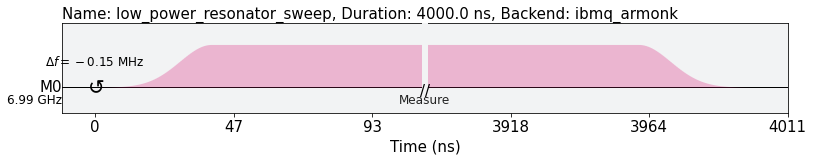

In [9]:
low_power_schedules[0].draw(backend=backend)

Here we send our pulse sequence to the hardware.

In [10]:
#from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 2*1024

job_low_power = backend.run(low_power_schedules, 
                            meas_level=1, 
                            meas_return='avg', 
                            shots=num_shots_per_frequency)
job_monitor(job_low_power)

low_power_sweep_results = job_low_power.result(timeout=120)

Job Status: job has successfully run


And then we access the measurement data. The resonator in the backend we use for this tutorial is measured reflectively, so the spectroscopy data is encoded in the phase of the output signal. We fit a Lorentzian function to the data to extract the resonator frequency and linewidth.

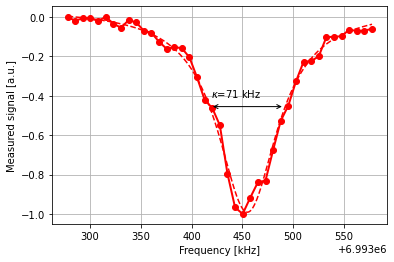

In [7]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results.results)):
    res_low_power = low_power_sweep_results.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

### 2. Measuring $\chi$ and $g$

Next, we measure the qubit-resonator coupling. One method for measuring the dispersive shift ($\chi$) and subsequently the qubit-resonator coupling ($g=\sqrt{\chi.\Delta}$) is to compare the resonator frequency in the dispersive limit with the frequency in the non-interactive regime, where the resonator does not get shifted by $\chi$. In the non-interactive limit the resonator photon number $n=a^\dagger a$ is larger than $n_c=\frac{\Delta^2}{4g^2}$. In experiment we can populate the resonator with more photons by driving it with more power.

In [11]:
#with pulse.build(backend) as readout_drive_high_power:
#    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
#    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
#    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
#    meas_chan = pulse.measure_channel(mem_slot)
#    pulse.play(pulse.GaussianSquare(duration = duration,
#                                    amp = 1, # High drive amplitude
#                                    sigma = sigma,
#                                    width = width,
#                                    name = 'high power readout tone'), meas_chan)

In [12]:
# build the pulse sequence for low power resonator spectroscopy
freq = Parameter('freq')
with pulse.build(backend=backend, name='high_power_resonator_sweep') as pulse_high_power:
    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
    acq_chan = pulse.acquire_channel(mem_slot)
    meas_chan = pulse.measure_channel(mem_slot)
    pulse.set_frequency(freq, meas_chan)
    #drive the resonator with high power
    pulse.play(pulse.GaussianSquare(duration = duration,
                                    amp = 1, # High drive amplitude
                                    sigma = sigma,
                                    width = width,
                                    name = 'high power readout tone'), meas_chan)
    #pulse.call(readout_drive_high_power)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
                  qubit_or_channel = acq_chan,
                  register = pulse.MemorySlot(mem_slot))

In [13]:
schedule_frequencies = [pulse_high_power.assign_parameters({freq: f}, inplace=False) for f in frequencies_range]

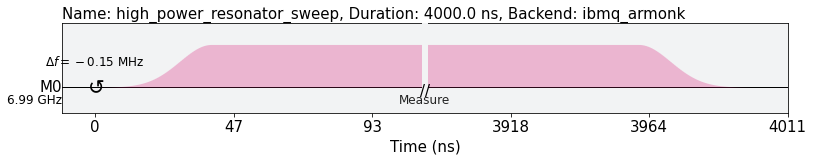

In [14]:
schedule_frequencies[0].draw(backend=backend)

Here we send our pulse sequence to the hardware.

In [15]:
frequency_sweep_high_power = backend.run(schedule_frequencies, 
                                         meas_level=1, 
                                         meas_return='avg', 
                                         shots=num_shots_per_frequency)

job_monitor(frequency_sweep_high_power)

high_power_sweep_results = frequency_sweep_high_power.result(timeout=120)

Job Status: job has successfully run


And then we access the measurement data for the high power resonator spectroscopy scan.

In [11]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power,_=fit_lorentzian(frequencies_range,high_power_sweep_values)

Finally we plot the high power resonator spectroscopy next to the low power scan from the previous section and use the shift in resonator frequency to calculate $\chi$.

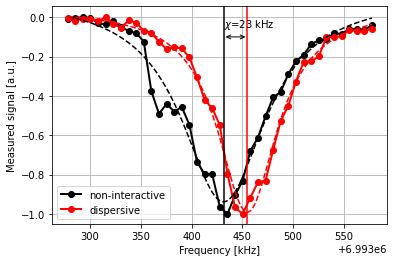

chi=23.5 kHz
g=6.9 MHz


In [12]:
plt.plot(frequencies_range/1e3, high_power_sweep_values, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

### 3. Measuring $\gamma$

A qubit coupled to a resonator will spontaneous emit photons into the cavity, and therefore relaxing from an excited state to the ground state. The spontaneous emission of photons gets enhanced by the qubit environment, a phenomenon known as the Purcell effect. We can measure the qubit decay rate $\gamma$ by exciting the qubit with a microwave drive, and measuring the decay rate $T_1=1/\gamma$ of the qubit excitation. This experiment is a common method method for measuring qubit coherence properties as discussed in this <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a>. For this experiment our microwave drive doesn't have to be $\pi$-pulse.

In [17]:
drive_sigma = 100e-9
drive_duration = 8*drive_sigma

# We drive our qubit, wait for some time (time delay), and then measure the qubit
# Using these measurements we can create a plot of qubit population vs. time delay
delay_times=np.linspace(0, 600e-6, 61) #measurement time delays
qubit_decay_pulses = []
for delay in delay_times:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"decay delay = {delay * 1e6} us") as temp_decay_pulse:
        drive_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(mem_slot)
        acq_chan = pulse.acquire_channel(mem_slot)
        # setting the readout frequency to the resontor frequecy in the dispersive limit measured earlier
        # setting the qubit freqency to the default value
        pulse.set_frequency(f0, meas_chan)
        #pulse.set_frequency(backend_defaults.qubit_freq_est[qubit], drive_chan)
        #drive the qubit
        pulse.play(pulse.Gaussian(duration=get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration)),
                                  amp=.5,
                                  sigma=get_closest_multiple_of_16(pulse.seconds_to_samples(drive_sigma)),
                                  name='qubit tone'), drive_chan)
        #meanwhile do nothing with the resonator
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration)), meas_chan)
        #wait for the duration of the time delay before measuring the qubit
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), meas_chan)
        
        
        with pulse.align_left():
            duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
            sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
            width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
            #drive the resonator with low power
            pulse.play(pulse.GaussianSquare(duration = duration,
                                            amp = .3,
                                            sigma = sigma,
                                            width = width,
                                            name = 'low power readout tone'), meas_chan)
            #pulse.call(readout_drive_low_power)
            #acquire the readout signal
            pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
                          qubit_or_channel = acq_chan,
                          register = pulse.MemorySlot(mem_slot))
        
        #sequence for measuring the qubit
        #with pulse.build(backend=backend) as temp_sched:
        #    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time))
        #    sigma = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_sigma))
        #    width = get_closest_multiple_of_16(pulse.seconds_to_samples(readout_time-8*readout_sigma))
            #drive the resonator with low power
        #    pulse.play(pulse.GaussianSquare(duration = duration,
        #                                    amp = .3,
        #                                    sigma = sigma,
        #                                    width = width,
        #                                    name = 'low power readout tone'), meas_chan)
            #pulse.call(readout_drive_low_power)
            #acquire the readout signal
        #    pulse.acquire(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(acquisition_time)),
        #                    qubit_or_channel = acq_chan,
        #                    register = pulse.MemorySlot(mem_slot))
        
        #call the measuring sequence
        #pulse.call(temp_sched)
        
    qubit_decay_pulses.append(temp_decay_pulse)

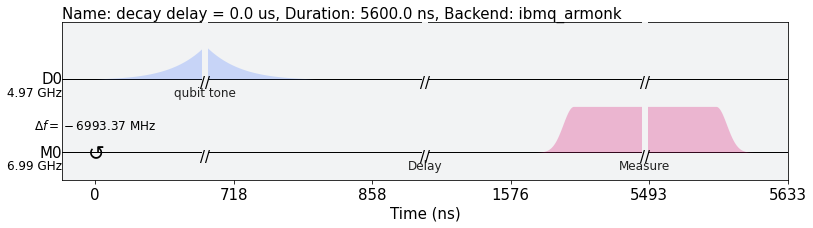

In [18]:
qubit_decay_pulses[0].draw(backend=backend)

Here we send our pulse sequence to the hardware.

In [19]:
num_shots = 4*1024  # increasing this number will make your output more accurate,
                    # but it will slow down the experiment

job_qubit_decay = backend.run(qubit_decay_pulses, 
                              meas_level=1, 
                              meas_return='avg', 
                              shots=num_shots)

job_monitor(job_qubit_decay)

Job Status: job has successfully run


And then we access the measurement data. We fit an exponential to the data to extract the decay time constant.

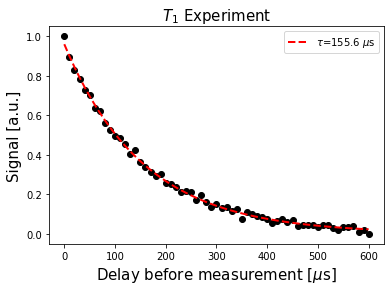

gamma=  6.43 kHz


In [25]:
qubit_decay_results = job_qubit_decay.result(timeout=120)

qubit_decay_values = []
for i in range(len(delay_times)):
    qubit_decay_values.append(qubit_decay_results.get_memory(i)[qubit])
qubit_decay_values = np.abs(qubit_decay_values)
qubit_decay_values = (qubit_decay_values-min(qubit_decay_values))
qubit_decay_values/=max(qubit_decay_values)

decay_popt,_=fit_exponential(delay_times, qubit_decay_values)
tau=decay_popt[0]
g=1/tau

plt.scatter(delay_times*1e6, qubit_decay_values, color='black') 
plt.plot(delay_times*1e6,exponential(delay_times,*decay_popt),'--',lw=2,color='red',label=r'$\tau$={:.1f} $\mu$s'.format(tau*1e6))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

print(r'gamma=  {:.2f} kHz'.format(g/1e3))

In this chapter, we introduce the Jaynes-Cummings model and we consider the relevant quantities for a system consisting of a qubit coupled to a cavity. We use Qiskit Pulse to extract the qubit-resonator coupling strength $g$, the qubit spontaneous emission rate $\gamma$, and the cavity decay rate $\kappa$. These parameters combined with the qubit frequency and the resonator frequency that we measured in a previous <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a> allow us to describe our qubit-resonator system.

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.7.0',
 'qiskit-ignis': '0.5.0',
 'qiskit-ibmq-provider': '0.11.0',
 'qiskit-aqua': '0.8.0',
 'qiskit': '0.23.0'}